In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare
import matplotlib.colors

In [2]:
#patient_id = 'id030_bf'
patient_id = 'id017_mk'
data_dir = f'/home/hfw/Retro/datasets/{patient_id}'
results_dir = f'/home/hfw/Retro/results/{patient_id}'
#szr_name = 'BF_crise1P_110831B-CEX_0004'
#szr_name = 'BF_crise1P_110831B-CEX_0004'
szr_name = "MK_crise1Part1_170328C-BEX_0004_MK_crise1Part2_170328C-BEX_0007"
#szr_name = "MK_crise2_PSG_170328C-CEX_0002"
#szr_name = 'BTcrise2appportable_0013'
#szr_name = 'BTcrise1appportable_0006'
meta_data_fname = f'{szr_name}.json'
#raw_seeg_fname = f'{szr_name}.raw.fif'
fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
hpf = 10
lpf = 0.02
# ezdelay, ezhyp, PUni
fname_suffix = f'{szr_name}_hpf{hpf}_lpf{lpf}_ezdelay'

raw_seeg_fname = f'{szr_name}.raw.fif'
#data_mono = retro_prepare_data.prepare_data(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#raw_seeg_fname = f'{szr_name}.bip.raw.fif'
data = retro_prepare.prepare_data_bip(data_dir, meta_data_fname, raw_seeg_fname, szr_name, hpf, lpf)
#fname_suffix += f'_hpf{hpf}_lpf{lpf}'

Isotrak not found


/opt/conda/envs/jhub/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [4]:
seeg, bip = retro_prepare.read_one_seeg(data_dir, meta_data_fname, raw_seeg_fname)
slp = retro_prepare.compute_slp(seeg, bip, hpf, lpf)

Isotrak not found


In [5]:
def read_ez_sens_mask(sid, ch_names):
    xlsx_file = os.path.join(sid, "patient.xlsx")
    CONTACTS_IND = 6
    EZ_IND = 7
    df = pd.read_excel(xlsx_file, sheet_name="EZ hypothesis and EI", header=1)
    ez_contacts = []
    contacts_col = df.iloc[:, CONTACTS_IND]
    mask = contacts_col.notnull()
    contacts_names = contacts_col[mask]
    ez_mask = df.iloc[:, EZ_IND][mask] == "YES"
    ez_contacts.extend(contacts_names[ez_mask])
    # OR1-OR2 -> OR1-2
    # TODO handle the case monopolar
    ez_contacts_ = []
    cre = re.compile("([A-Za-z'p]+)([0-9]+)-([A-Za-z'p]+)([0-9]+)")
    cre_mono = re.compile("([A-Za-z'p]+)([0-9]+)")
    for ez_contact in ez_contacts:
        try:
            nm, i, _, j = cre.match(ez_contact).groups()
            ez_contacts_.append(f"{nm}{i}-{j}")
        except Exception as exc:
            try:
                nm, i = cre_mono.match(ez_contact).groups()
                ez_contacts_.append(f"{nm}{i}-{int(i)+1}")
            except Exception as exc:
                print(sid, ez_contact, exc)
                continue
    m_ez = np.array([_ in ez_contacts_ for _ in ch_names])
    return m_ez

In [6]:
import mne
import pandas as pd
import re

In [7]:
#raw = retro_prepare.load_raw_fif(meta_data_fname)
'''raw = mne.io.Raw(
                os.path.join(data_dir, 'seeg', 'fif', raw_seeg_fname),
                verbose='WARNING',
                preload=True)
'''
ezh = read_ez_sens_mask(data_dir, bip.ch_names)


In [8]:
for ichan, iez in zip(bip.ch_names,ezh):
    if iez:
        print(ichan)


TP'1-2
TP'2-3
TP'4-5
TP'5-6
TB'1-2
TB'2-3
TB'3-4
A'1-2
A'2-3
A'3-4
A'4-5
B'1-2
B'2-3
B'3-4
GPH'1-2
GPH'2-3
GPH'3-4
GPH'4-5


/opt/conda/envs/jhub/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


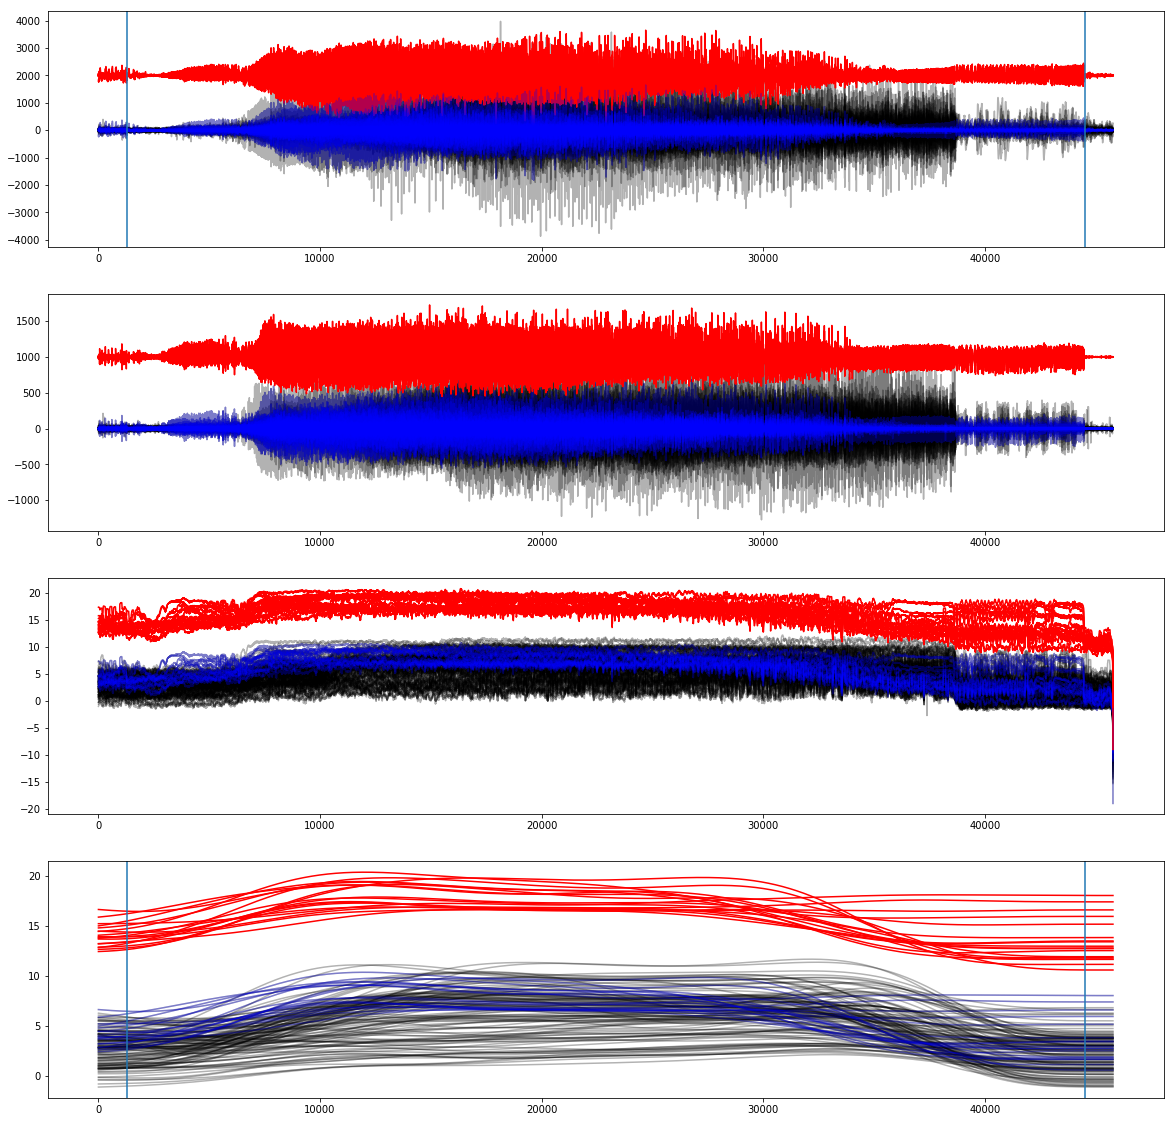

In [9]:
#seeg = retro_prepare_data.read_one_bip_seeg(data_dir, meta_data_fname, raw_seeg_fname)
ts = 5
base_length = int(seeg['sfreq']*ts)

start_idx = int(seeg['onset'] * seeg['sfreq']) - base_length
end_idx = int(seeg['offset'] * seeg['sfreq']) + base_length
slp = bip.get_data().T[start_idx:end_idx]
#slp = seeg['time_series'].copy()
# Remove outliers i.e data > 2*sd
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh]+2000,color='red');
plt.plot(slp[:,ezh],color='blue', alpha = 0.3);
plt.axvline(int(seeg['sfreq']*ts))
plt.axvline(len(slp)-int(seeg['sfreq']*ts))


for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# High pass filter the data
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], hpf, 'highpass', axis=0)
plt.subplot(412)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+1000,color='red');

# Compute seeg log power
slp = lib.preprocess.envelope.seeg_log_power(slp, 100)
plt.subplot(413)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+10,color='red');

# Remove outliers i.e data > 2*sd
for i in range(slp.shape[1]):
    ts = slp[:, i]
    ts[abs(ts - ts.mean()) > 2 * ts.std()] = ts.mean()
# Low pass filter the data to smooth
slp = lib.preprocess.envelope.bfilt(
    slp, seeg['sfreq'], lpf, 'lowpass', axis=0)

plt.subplot(414)
plt.plot(slp, color='black', alpha=0.3);
plt.plot(slp[:,ezh],color='blue',alpha = 0.3);
plt.plot(slp[:,ezh]+10,color='red');
plt.axvline(base_length)
plt.axvline(len(slp)-base_length)



In [8]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
data['nt'] = data['slp'].shape[0]
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.vep.txt') == 1)[0]
#data['x0_mu'] = -3.0*np.ones(data['nn'])

#data['x0_mu'][ez_hyp] = -1.5

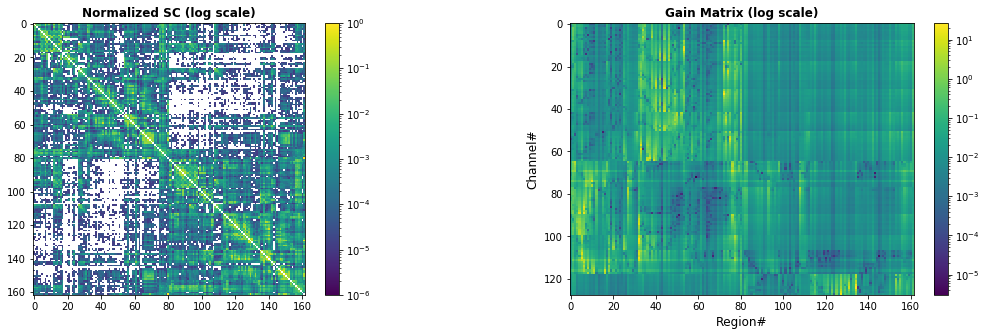

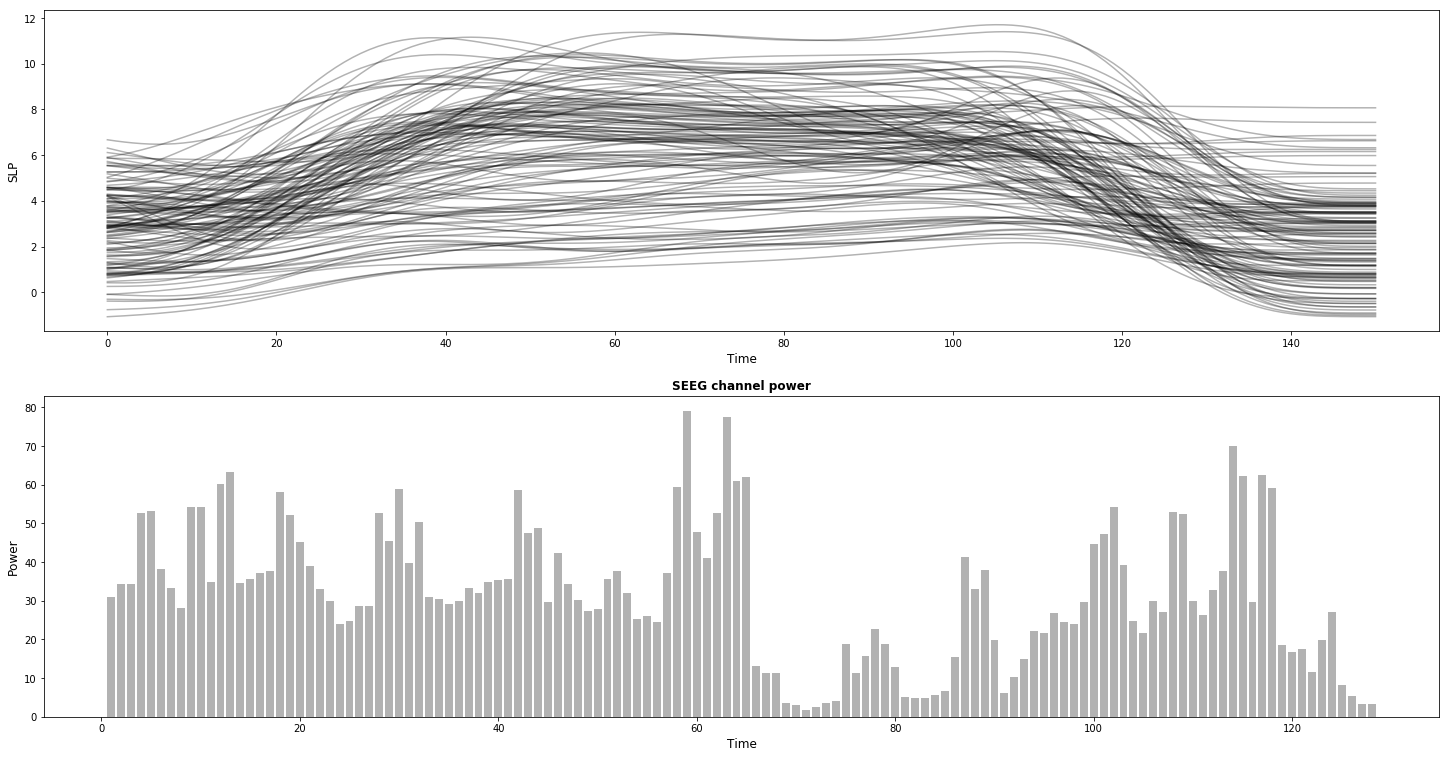

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


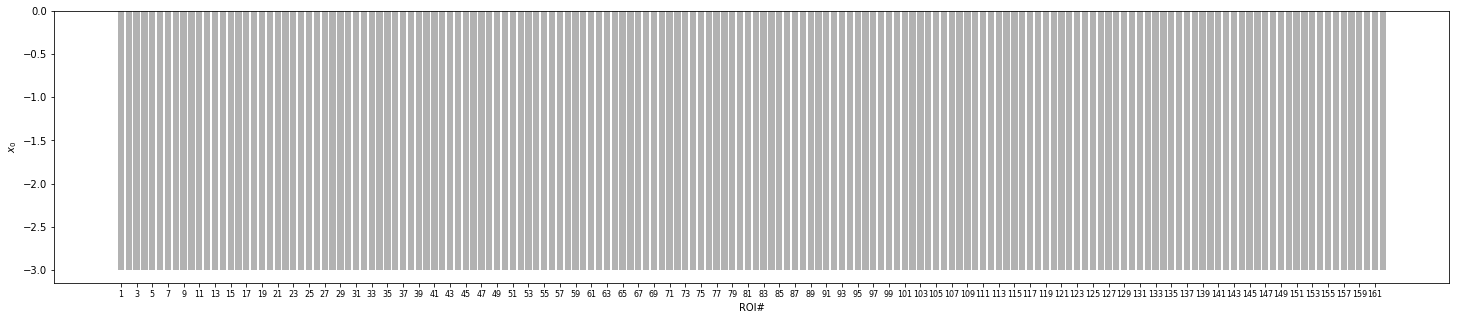

In [10]:
plt.figure(figsize=(25,5))
plt.bar(np.r_[1:data['nn']+1],data['x0_mu'], color='black', alpha=0.3)
plt.xticks(np.r_[1:data['nn']+1:2], fontsize=8);
plt.xlabel('ROI#')
plt.ylabel(r'$x_0$', fontsize=10)
plt.savefig(f'{results_dir}/figures/ez_hyp.png')

In [13]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain1.csv'])

print(pstr_samples['x0'],pstr_samples['tau0'])

[[-3.003   -3.23383 -3.40372 -3.00468 -1.83469 -2.79622 -2.09225 -3.17296
  -1.79693 -3.30842 -3.123   -1.65687 -3.17099 -3.00099 -2.97527 -3.08514
  -1.81261 -3.08885 -2.64778 -2.95969 -2.72408 -2.95205 -2.96797 -2.98991
  -2.99077 -2.65878 -2.90777 -3.31548 -3.09358 -2.99182 -2.97579 -2.92363
  -2.23085 -1.22207 -1.46702 -2.9553  -2.07273 -1.68425 -1.56701 -2.192
  -1.45922 -2.96289 -3.8374  -3.00773 -1.60986 -3.06831 -1.48034 -3.06576
  -3.11277 -3.37192 -1.77086 -3.01288 -1.69275 -1.58021 -2.97679 -2.98164
  -2.99222 -2.84559 -2.96927 -2.97416 -2.98503 -2.96269 -2.9954  -2.98909
  -2.99929 -3.00955 -3.00405 -2.99929 -3.00785 -3.0232  -2.99331 -2.99382
  -1.79748 -3.12176 -3.24732 -2.69934 -4.06425 -2.91432 -2.94055 -3.09988
  -3.24342 -3.01947 -3.10827 -3.14249 -3.00268 -3.00096 -2.9972  -3.00199
  -3.00559 -2.99504 -3.00741 -3.00449 -2.99969 -3.067   -3.02103 -2.98466
  -3.01309 -2.99755 -3.06102 -2.99838 -2.99634 -2.99723 -2.99092 -2.99885
  -2.99451 -2.99342 -2.99992 -2.99793 -3


chains = [1,2,3,4]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])

    print(pstr_samples['x0'],pstr_samples['tau0'])

In [14]:
def read_vep_mrtrix_lut():
    roi_names = []
    with open('../ANSM/util/data/VepMrtrixLut.txt', 'r') as fd:
        for line in fd.readlines():
            i, roi_name, *_ = line.strip().split()
            roi_names.append(roi_name)
            #roi_name_to_index[roi_name.lower()] = int(i) - 1
    return roi_names
roi = read_vep_mrtrix_lut()
roi=roi[1:]


In [15]:
ns=162
vep_smax = np.zeros(ns)
for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
   
    print(ibip_elec, ': ', roi[indroi_iv])

TP'1-2 :  Left-Rhinal-cortex
TP'2-3 :  Left-Rhinal-cortex
TP'3-4 :  Left-Temporal-pole
TP'4-5 :  Left-Temporal-pole
TP'5-6 :  Left-T1-lateral-anterior
TP'6-7 :  Left-T1-lateral-anterior
TP'7-8 :  Left-Temporal-pole
TP'8-9 :  Left-T2-anterior
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
TB'4-5 :  Left-Rhinal-cortex
TB'5-6 :  Left-Rhinal-cortex
TB'6-7 :  Left-Rhinal-cortex
TB'7-8 :  Left-ITS-anterior
TB'8-9 :  Left-ITS-anterior
TB'9-10 :  Left-T2-anterior
TB'10-11 :  Left-T3-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
A'9-10 :  Left-Insula-gyri-longi
A'10-11 :  Left-STS-anterior
A'11-12 :  Left-STS-anterior
A'12-13 :  Left-T2-anterior
A'13-14 :  Left-T2-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B

A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


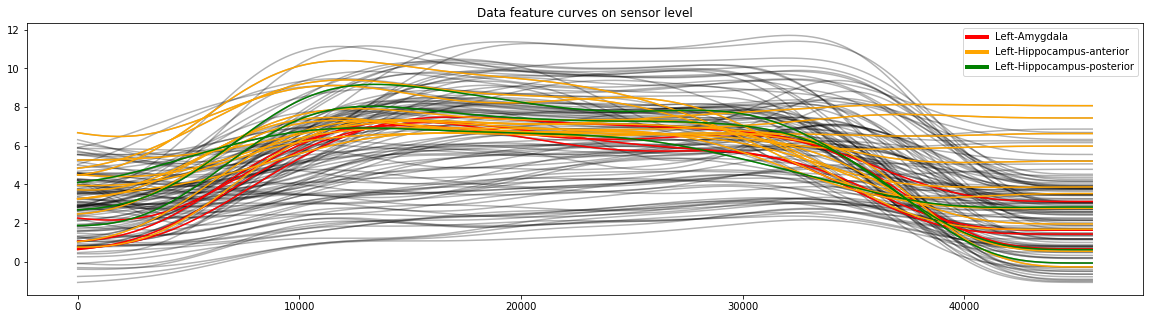

In [16]:
#roi_sel = ['Left-T1-lateral-anterior', 'Left-Hippocampus-anterior']


A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


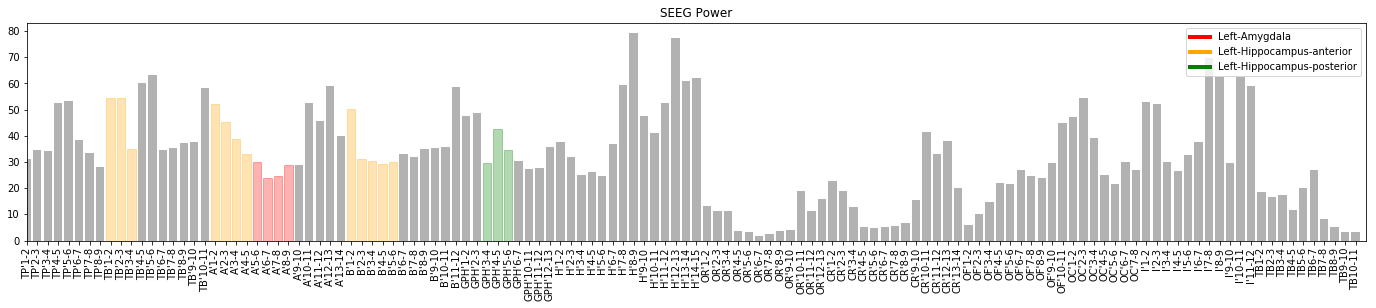

(-1, 163)

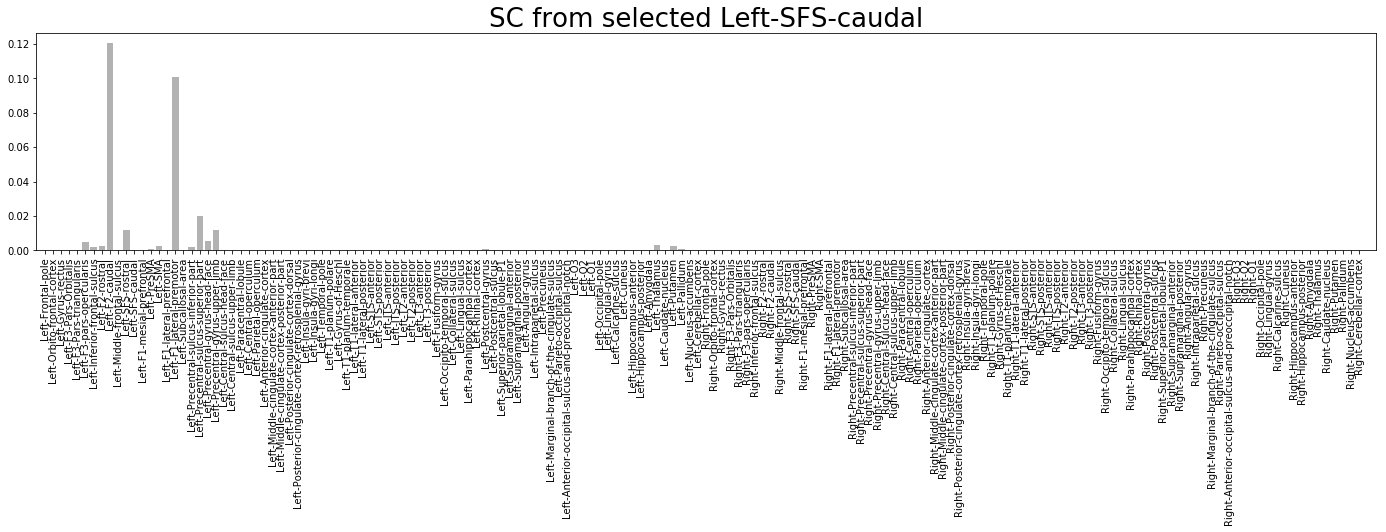

In [18]:
roi_given = 'Left-SFS-caudal'
plt.figure(figsize=(24,4))
barlist=plt.bar(np.arange(0, ns), data['SC'][roi.index(roi_given)], color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
plt.title(f'SC from selected {roi_given}', fontsize = 26);
plt.xlim([-1,163])

(-1, 128)

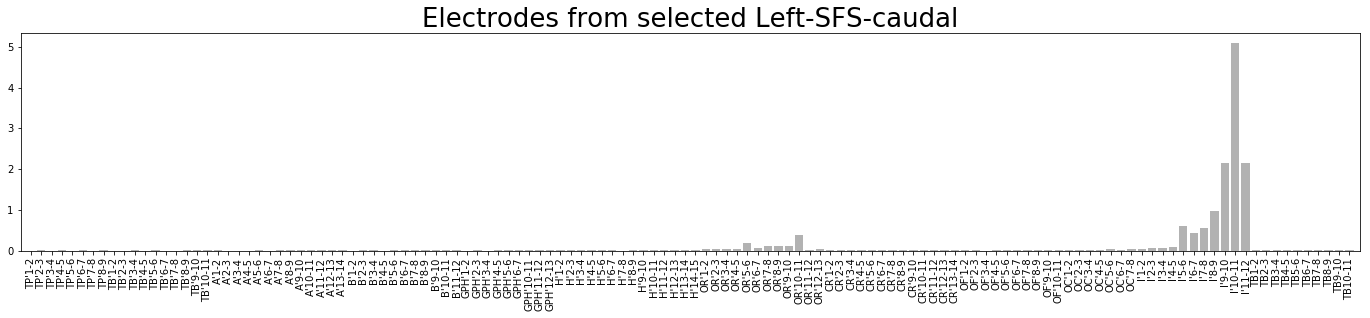

In [19]:
roi_given = 'Left-SFS-caudal'
plt.figure(figsize=(24,4))
barlist=plt.bar(np.arange(0, len(bip.ch_names)), data['gain'].T[roi.index(roi_given)], color='black', alpha=0.3)
plt.xticks(np.r_[:len(bip.ch_names)], bip.ch_names, rotation = 90);
plt.title(f'Electrodes from selected {roi_given}', fontsize = 26);
plt.xlim([-1,len(bip.ch_names)])

In [20]:
gain_roi_given=data['gain'].T[roi.index(roi_given)]

In [21]:
np.where(gain_roi_given>1)[0]

array([115, 116, 117])

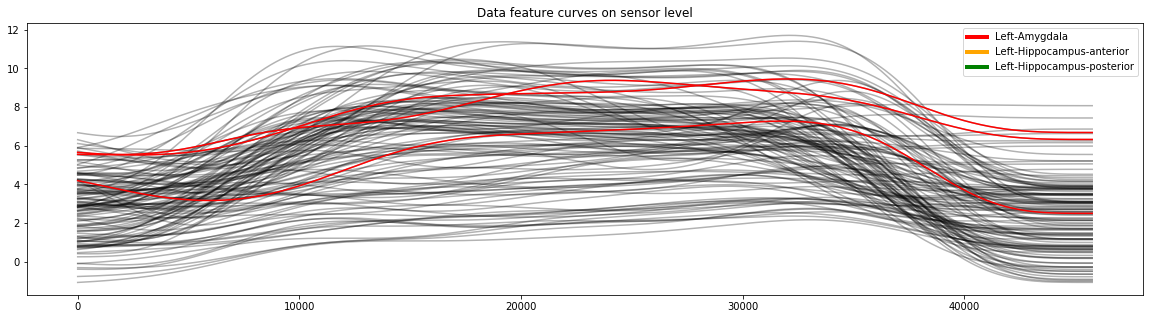

In [22]:
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)

legend_elements = []
for il, ilabel in enumerate(roi_sel):
    legend_elements.append(Line2D([0], [0], color=color[il], linewidth=4, label=ilabel))

plt.plot(slp, color='black', alpha=0.3);

#plt.plot(slp[:,np.argmax(gain_roi_given)],color='red',alpha = 1);
plt.plot(slp[:,np.where(gain_roi_given>1)[0]],color='red',alpha = 1)

plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)



In [23]:
plt.figure(figsize=(20,5))
ns=162
legend_elements = []
for il, ilabel in enumerate([roi_given]):
    legend_elements.append(Line2D([0], [0], color=color[il], linewidth=4, label=ilabel))
vep_smax = np.zeros(ns)
add='FP'
plt.plot(mu_slp, color='black', alpha=0.3);

plt.plot(mu_slp[:,np.where(gain_roi_given>1)[0]],color='red',alpha = 1);


plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)




NameError: name 'mu_slp' is not defined

<Figure size 1440x360 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)




plt.plot(pstr_samples['x'].mean(axis=0), color='black', alpha=0.3);

plt.plot(pstr_samples['x'].mean(axis=0)[:,roi.index(roi_given)],color='red',alpha = 1);


plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)



In [ ]:
#roi_sel = ['Left-T1-lateral-anterior', 'Left-Hippocampus-anterior']
#roi_sel = ['Left-Hippocampus-posterior', 'Left-Hippocampus-anterior']


In [ ]:
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)




plt.plot(pstr_samples['x'].mean(axis=0), color='black', alpha=0.3);

plt.plot(pstr_samples['x'].mean(axis=0)[:,np.where(ez_pred>1)[0]],color='red',alpha = 1);


plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)

In [24]:
import matplotlib.gridspec as gridspec

In [25]:
import json
with open(f'../ANSM/util/data/ei-final.json','r') as f:
    ezh_all = json.load(f)
ind_ez = ezh_all[patient_id]['i_ez']
ind_pz = ezh_all[patient_id]['i_pz']

In [26]:
[roi[iez] for iez in np.where(ez_pred>1.5)[0]]

NameError: name 'ez_pred' is not defined

In [ ]:
#lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(30,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
figsize = [25,30]
x0_infer = pstr_samples['x0']
ns = x0_infer.shape[1]
plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1,2,width_ratios = [1,8])

ax=plt.subplot(gs[0,0])
plt.barh(np.arange(0, ns), x0_infer[0][::-1]+5, color='black', alpha=0.3)
plt.yticks(np.r_[:len(roi)], roi[::-1]);

for ichanvep in ezh_all[patient_id]['i_ez']:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('red')
for ichanvep in ezh_all[patient_id]['i_pz']:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('blue')

plt.ylim([-2,ns])
ax2=plt.subplot(gs[0,1])
scaleplt=4
TimeSeries = pstr_samples['x'].mean(axis=0).T
TS = np.arange(np.shape(TimeSeries)[1])
for i in range(ns)[::-1]:
    plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'black', lw=0.4);
    if 161-i in ind_ez:
        plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'red', lw=0.6);
    if 161-i in ind_pz:
        plt.plot(TS, scaleplt*TimeSeries[i]/np.ptp(TimeSeries) + i, 'blue', lw=0.6);
plt.yticks(np.r_[:len(roi)], roi[::-1]);
for ichanvep in ind_ez:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('red')
for ichanvep in ind_pz:
            plt.gca().get_yticklabels()[161-ichanvep].set_color('blue')


#plt.ylim([-2,ns])
plt.xlim([0,TS[-1]])
plt.tight_layout()


In [27]:
ez_hyp = ezh_all[patient_id]['i_ez']

In [28]:
chain_no=1
onst_thrshld=0.0
csv_path=f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'
optima = lib.io.stan.read_samples([csv_path])
x = optima['x'][0]
nn = x.shape[1]
onsets = 200*np.ones(nn)
for i in range(nn):
    xt = x[:,i] > onst_thrshld
    if(xt.any()):
        onsets[i] = np.where(x[:,i] > onst_thrshld)[0][0]
ez_pred = -np.log(onsets/200)
#a, b = np.histogram(onsets[onsets<150])

#ez_pred = np.zeros(nn)
#ez_pred[np.where(onsets<b[1])] = 1

In [29]:
print(onsets,-np.log(onsets/200))

[200. 200. 200. 200.  92. 200. 200. 200.  76. 200. 200.  45. 200. 200.
 200. 200.  93. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200.  46.  17. 200. 200.  70.  32. 200.  39. 200.
 200. 200.  40. 200.  32. 200. 200. 200.   9. 200.  11.  27. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200.  35. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200.] [-0.         -0.         -0.         -0.          0.77652879 -0.
 -0.         -0.          0.96758403 -0.         -0.          1.49165488
 -0.         -0.         -0.         -0

In [30]:
def find_ez(onst_thrshld=0.0, csv_path='', save_dir=''):
    import numpy as np
    import lib.io.stan
    import os

    optima = lib.io.stan.read_samples([csv_path])
    x = optima['x'][0]
    nn = x.shape[1]
    onsets = 200*np.ones(nn)
    for i in range(nn):
        xt = x[:,i] > onst_thrshld
        if(xt.any()):
            onsets[i] = np.where(x[:,i] > onst_thrshld)[0][0]
    a, b = np.histogram(onsets[onsets<150])
    ez_pred = np.zeros(nn)
    ez_pred[np.where(onsets<b[1])] = 1
    np.save(os.path.join(save_dir, 'ez_pred.npy'), ez_pred)
    return ez_pred

In [31]:
ez_hyp = ezh_all[patient_id]['i_ez']
pz_hyp = ezh_all[patient_id]['i_pz']

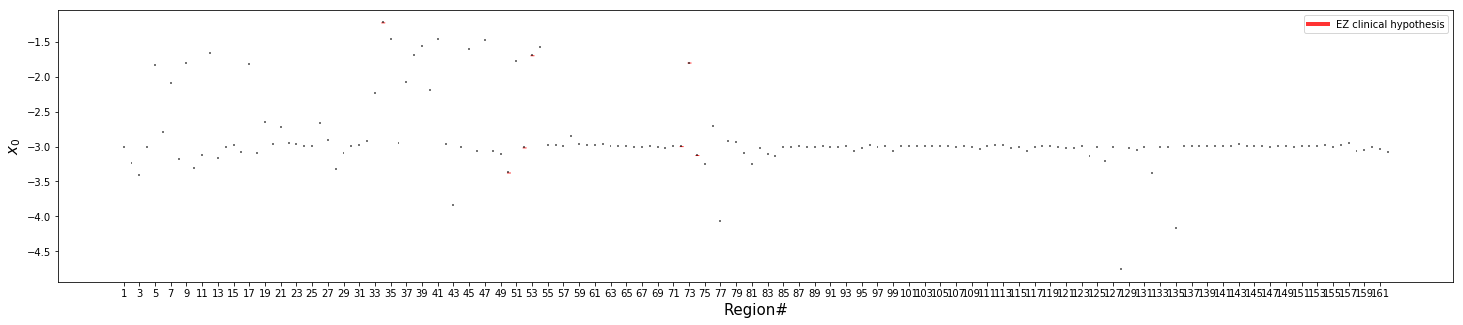

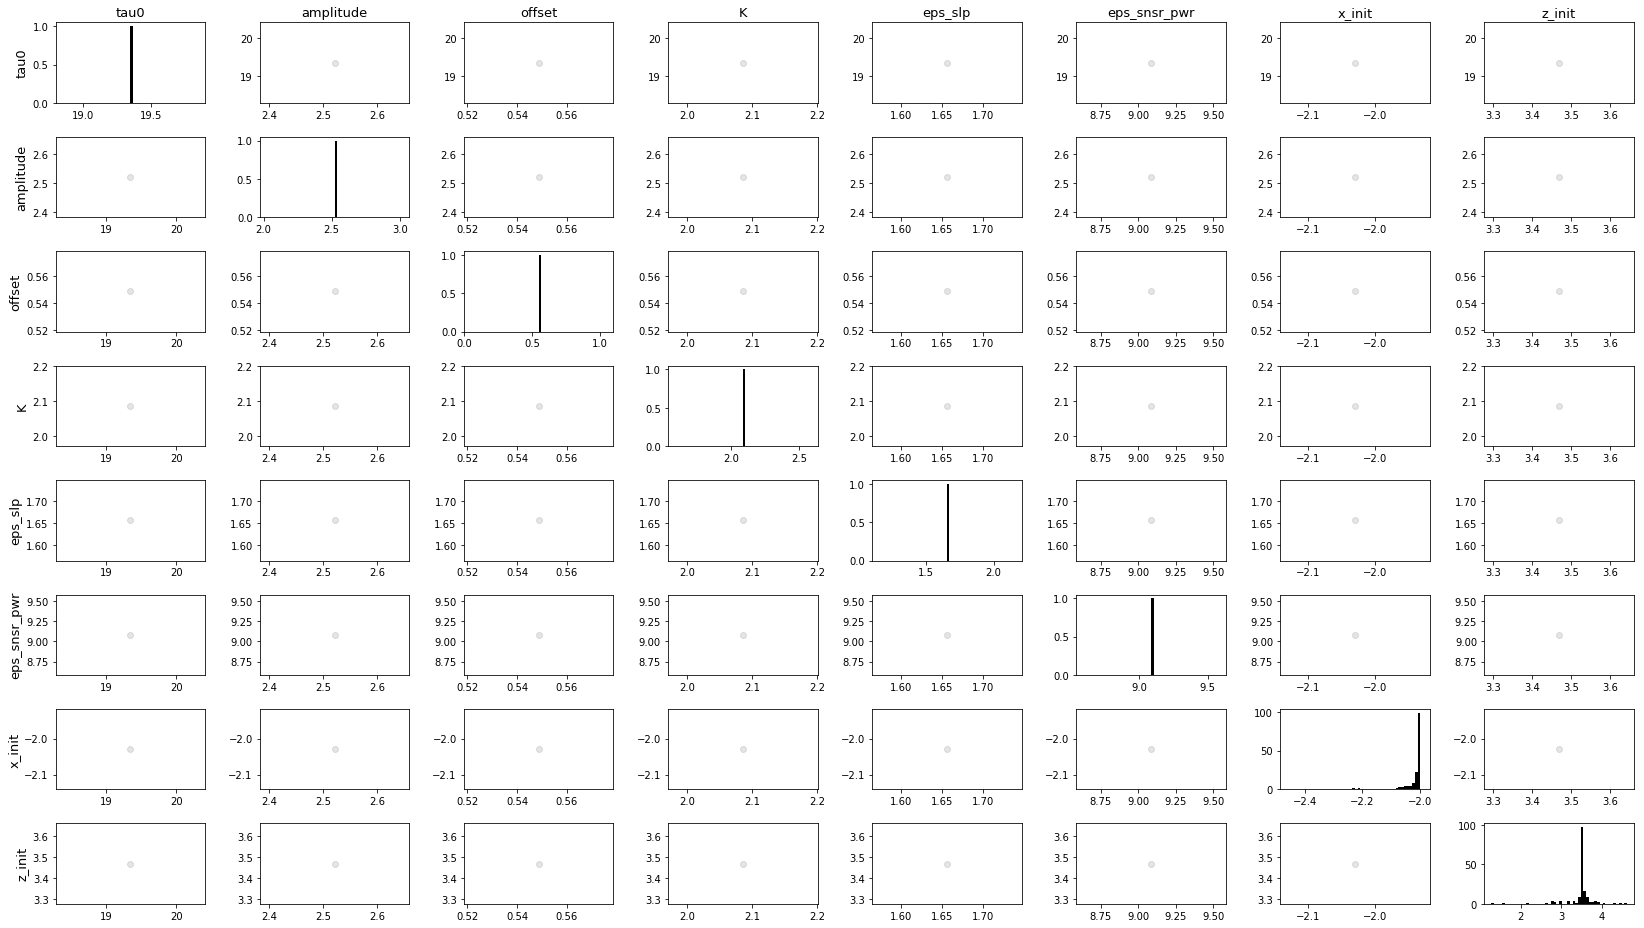

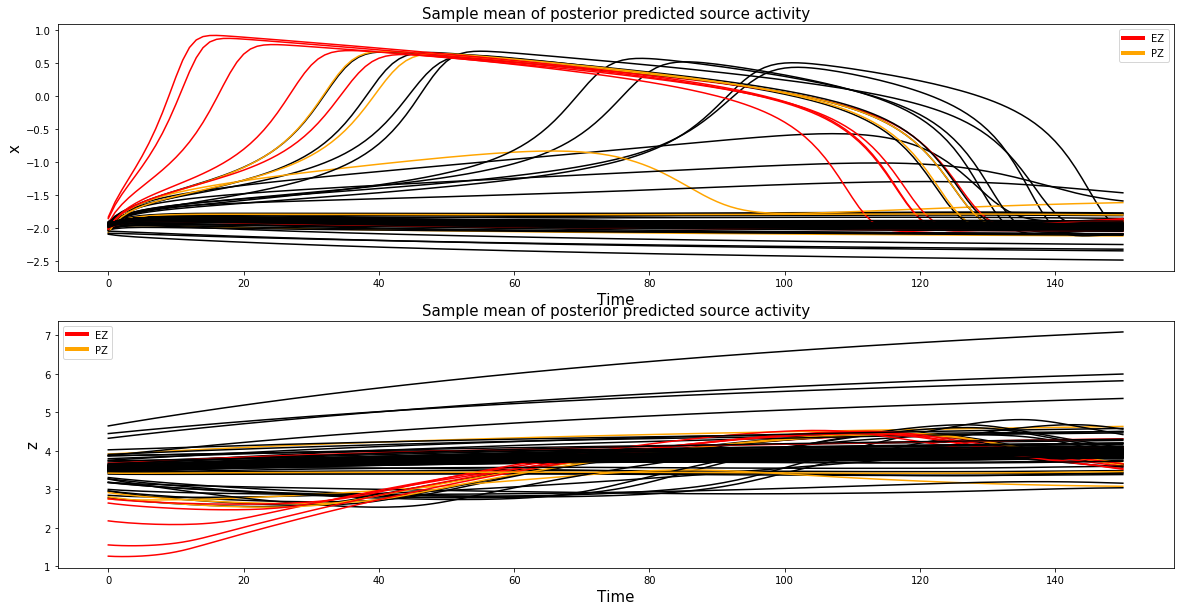

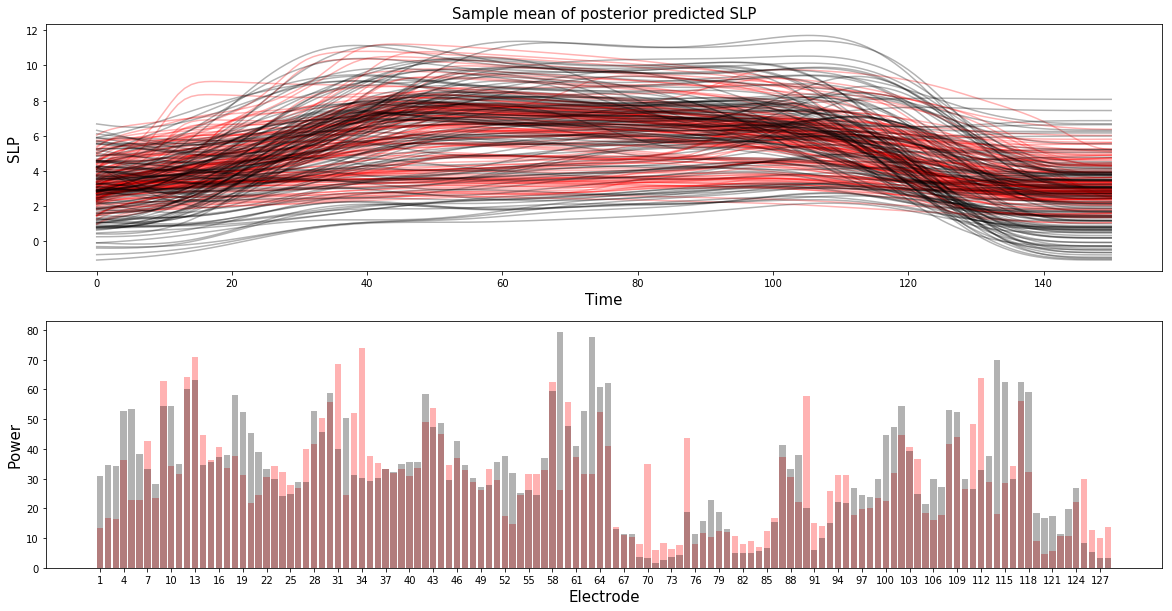

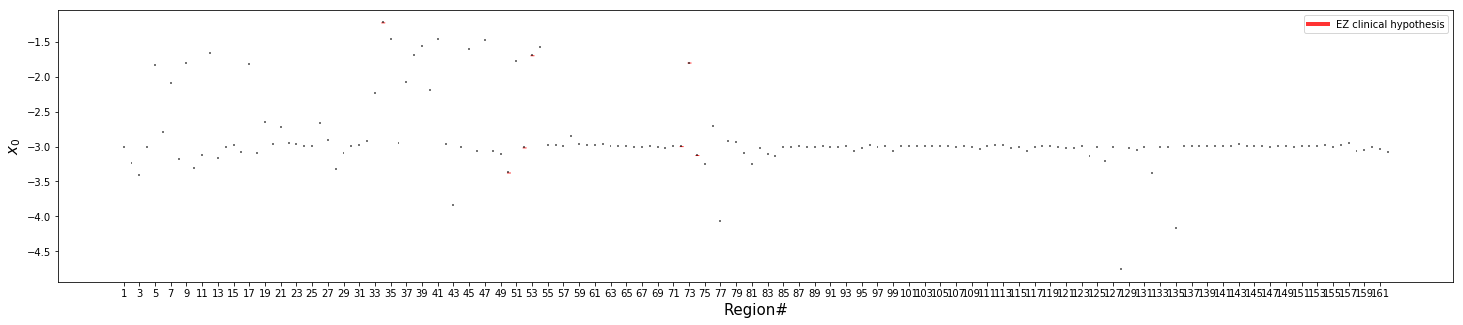

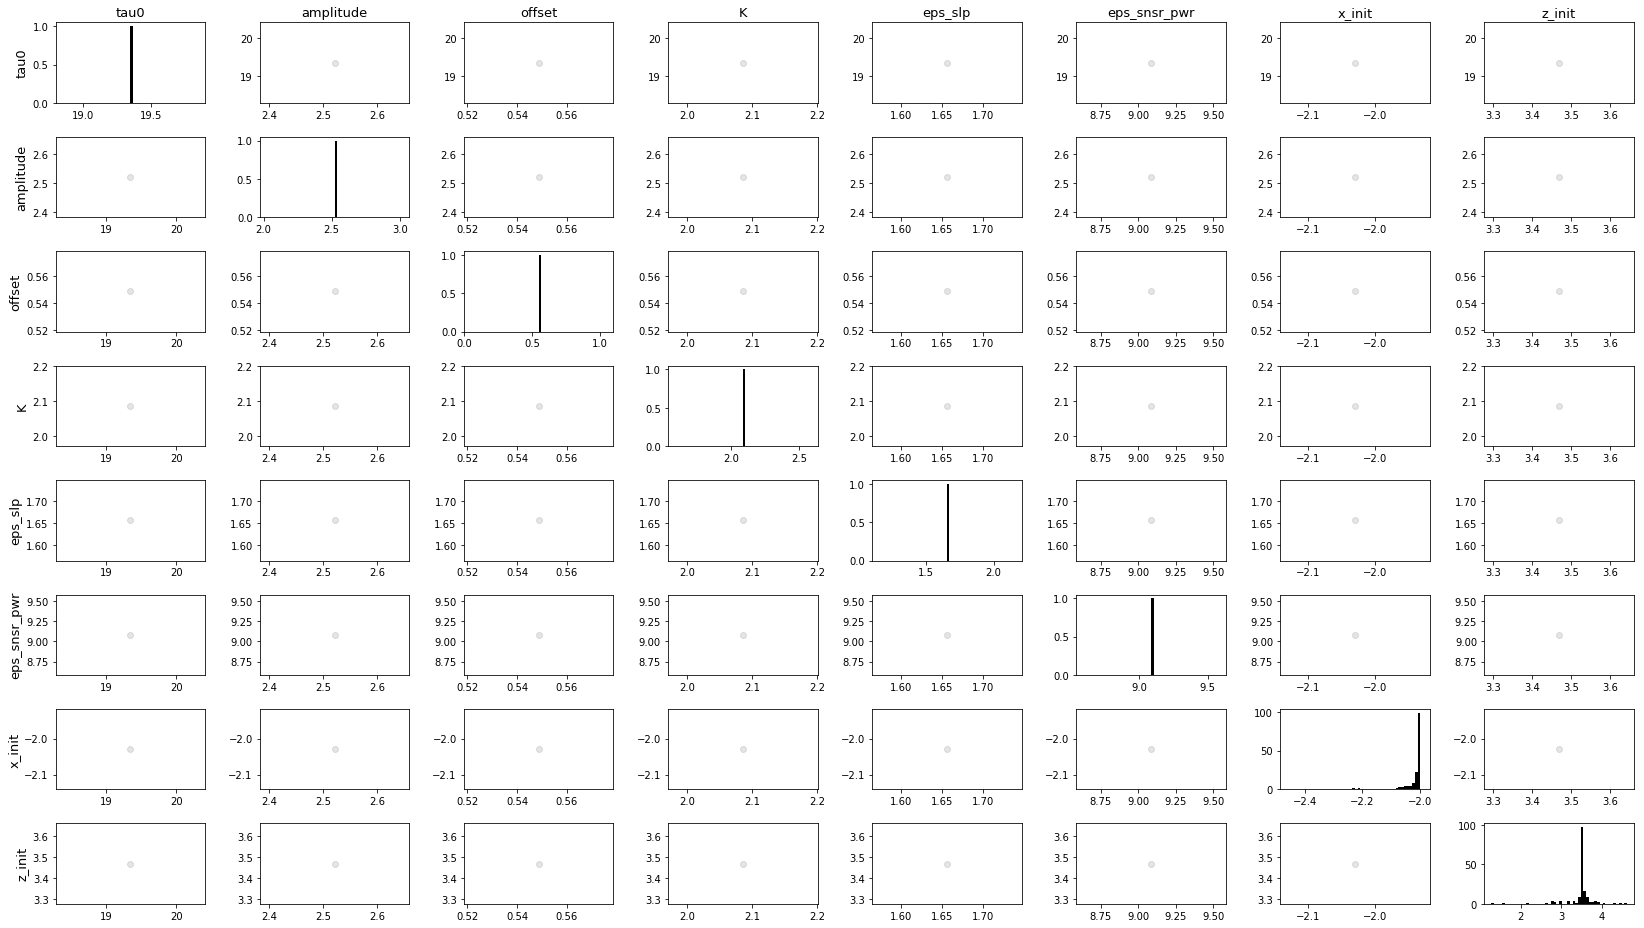

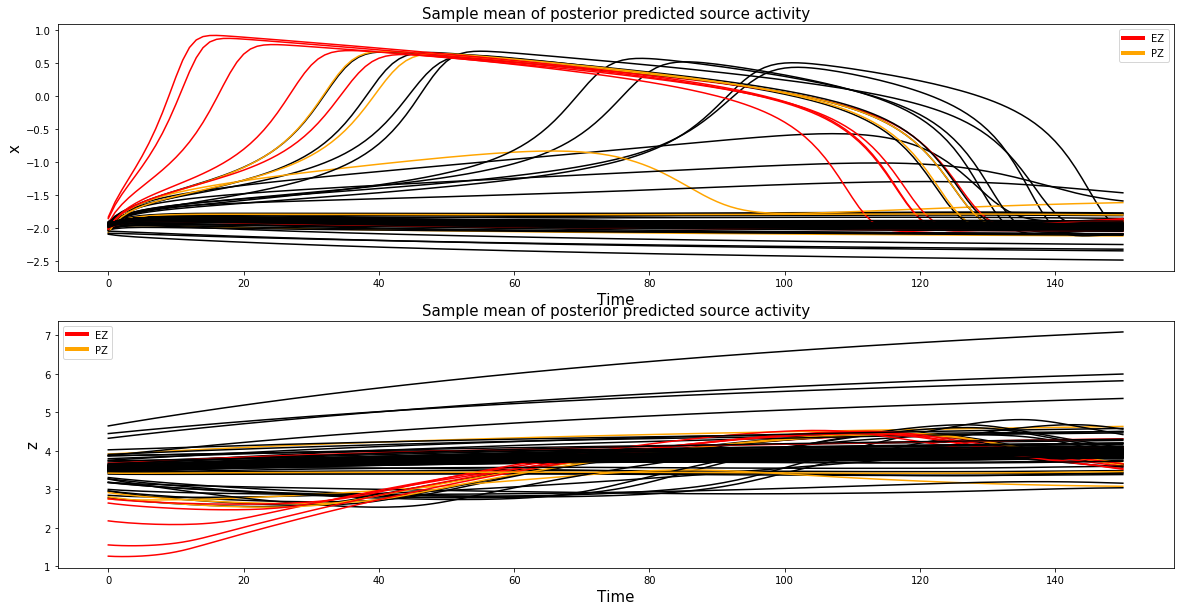

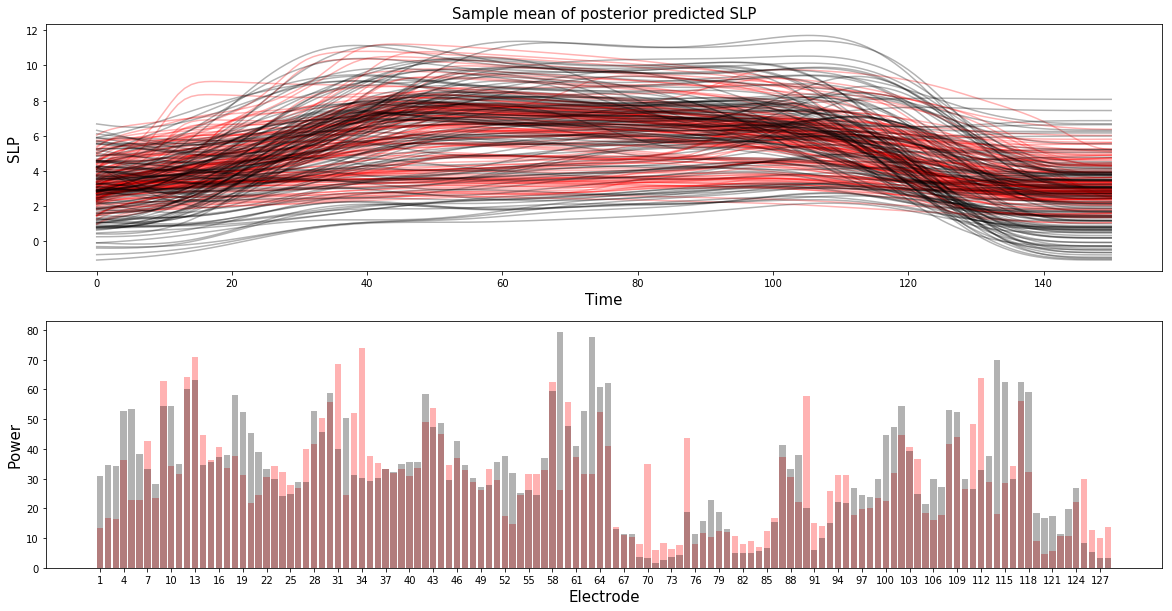

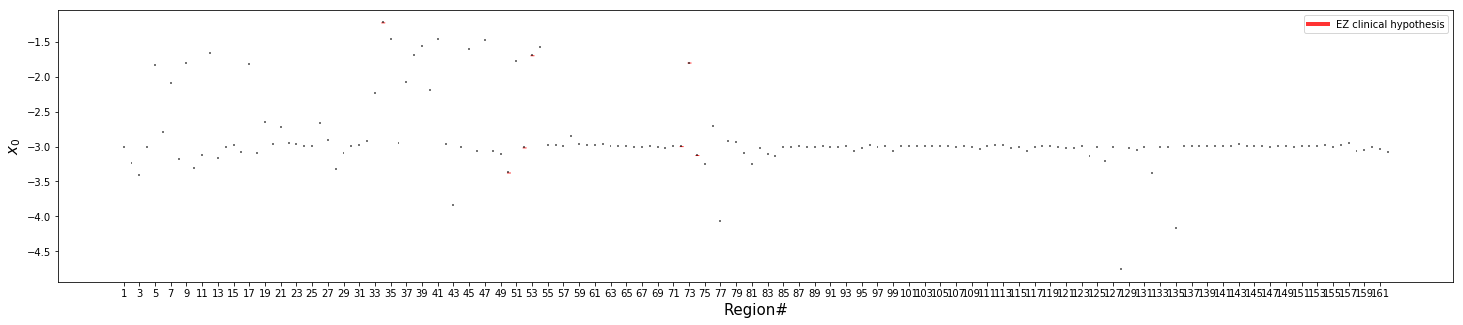

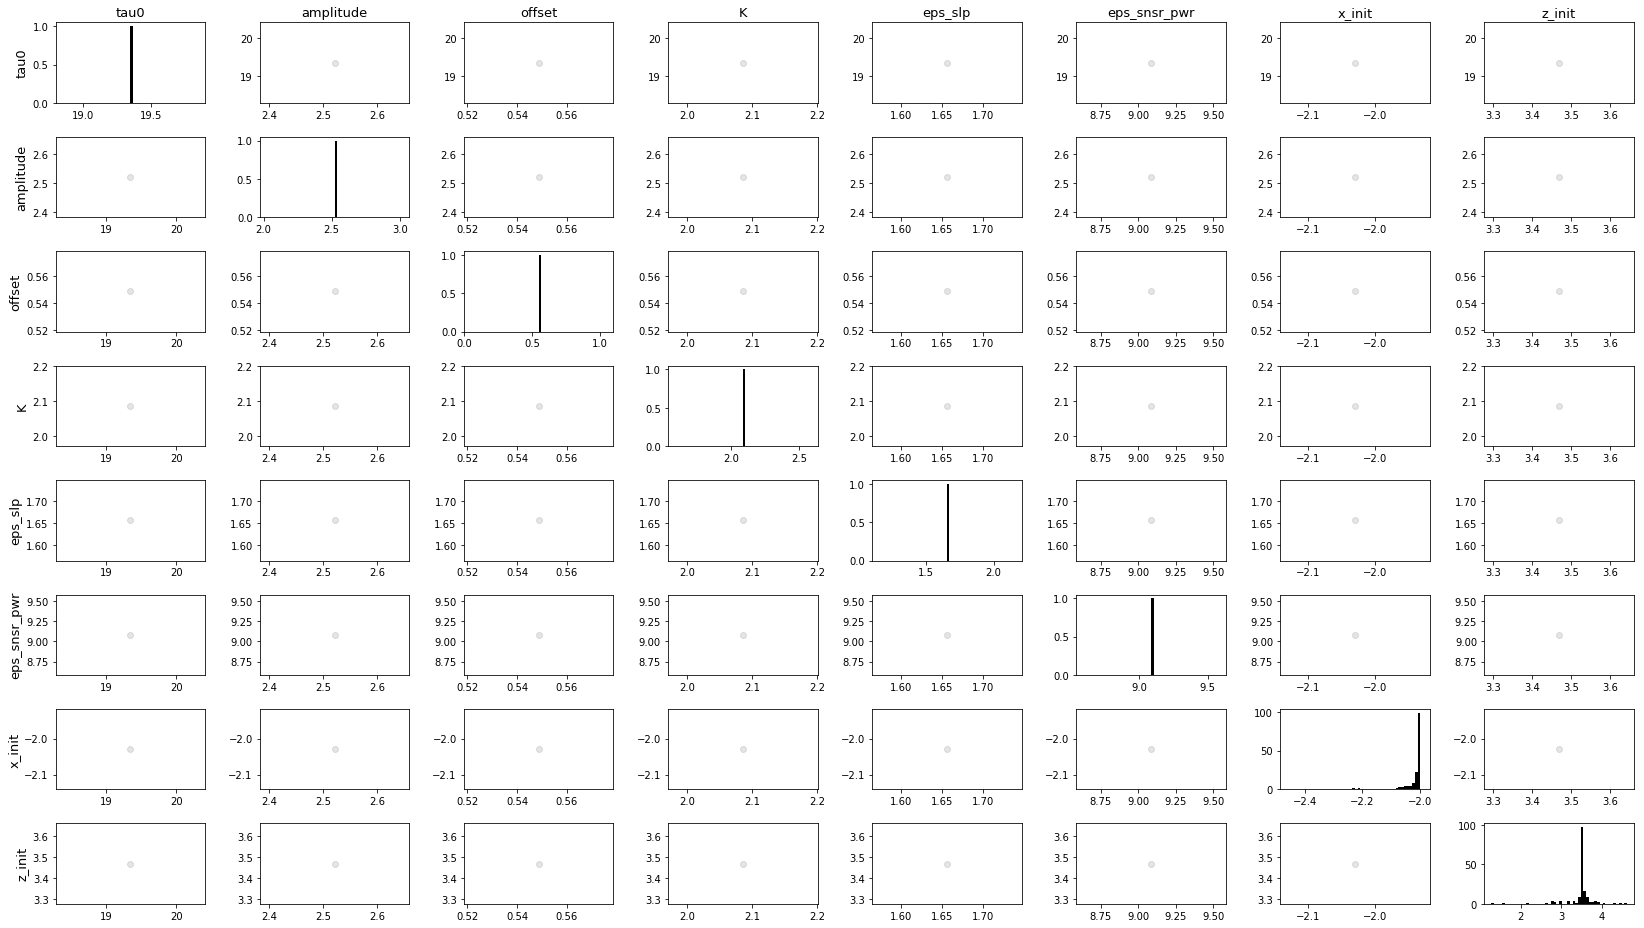

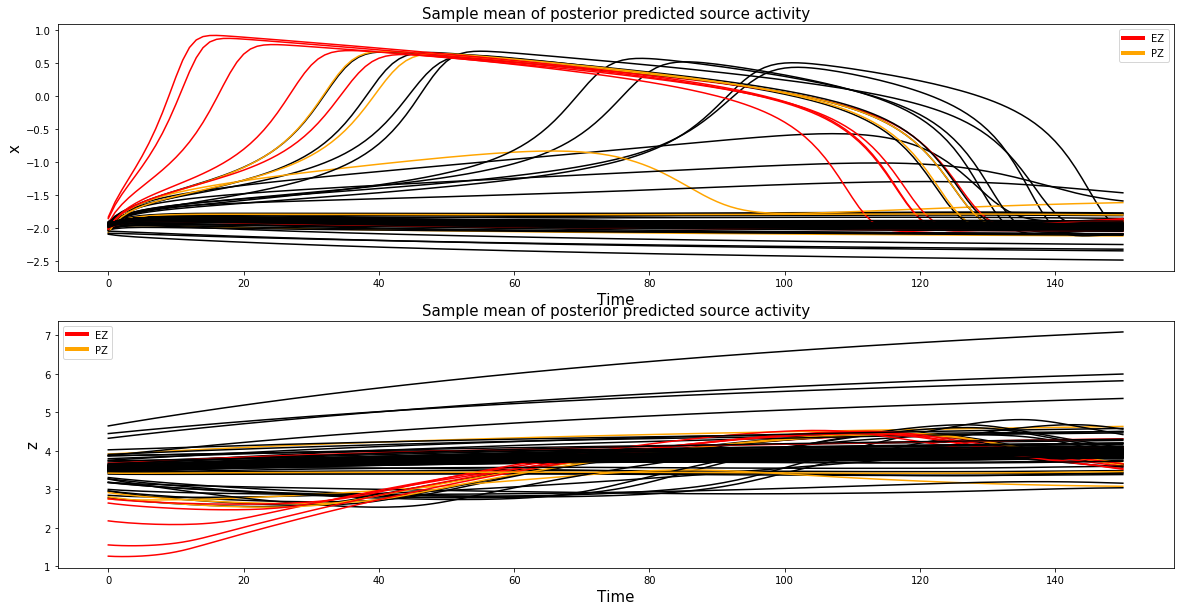

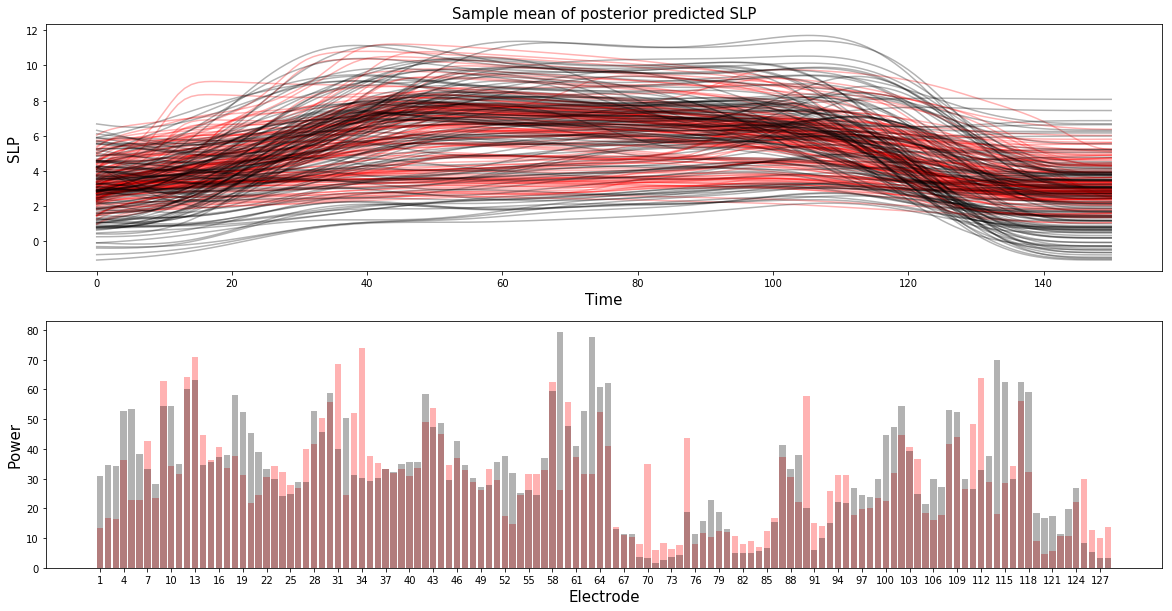

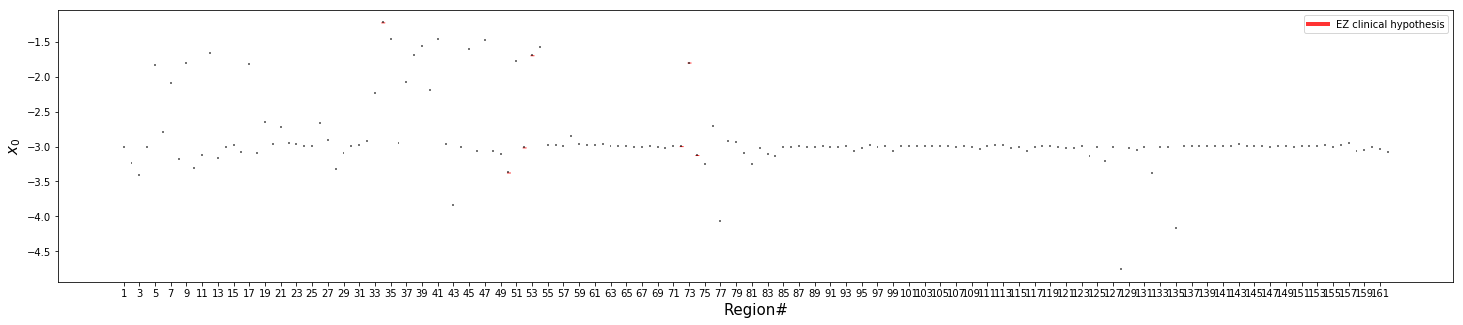

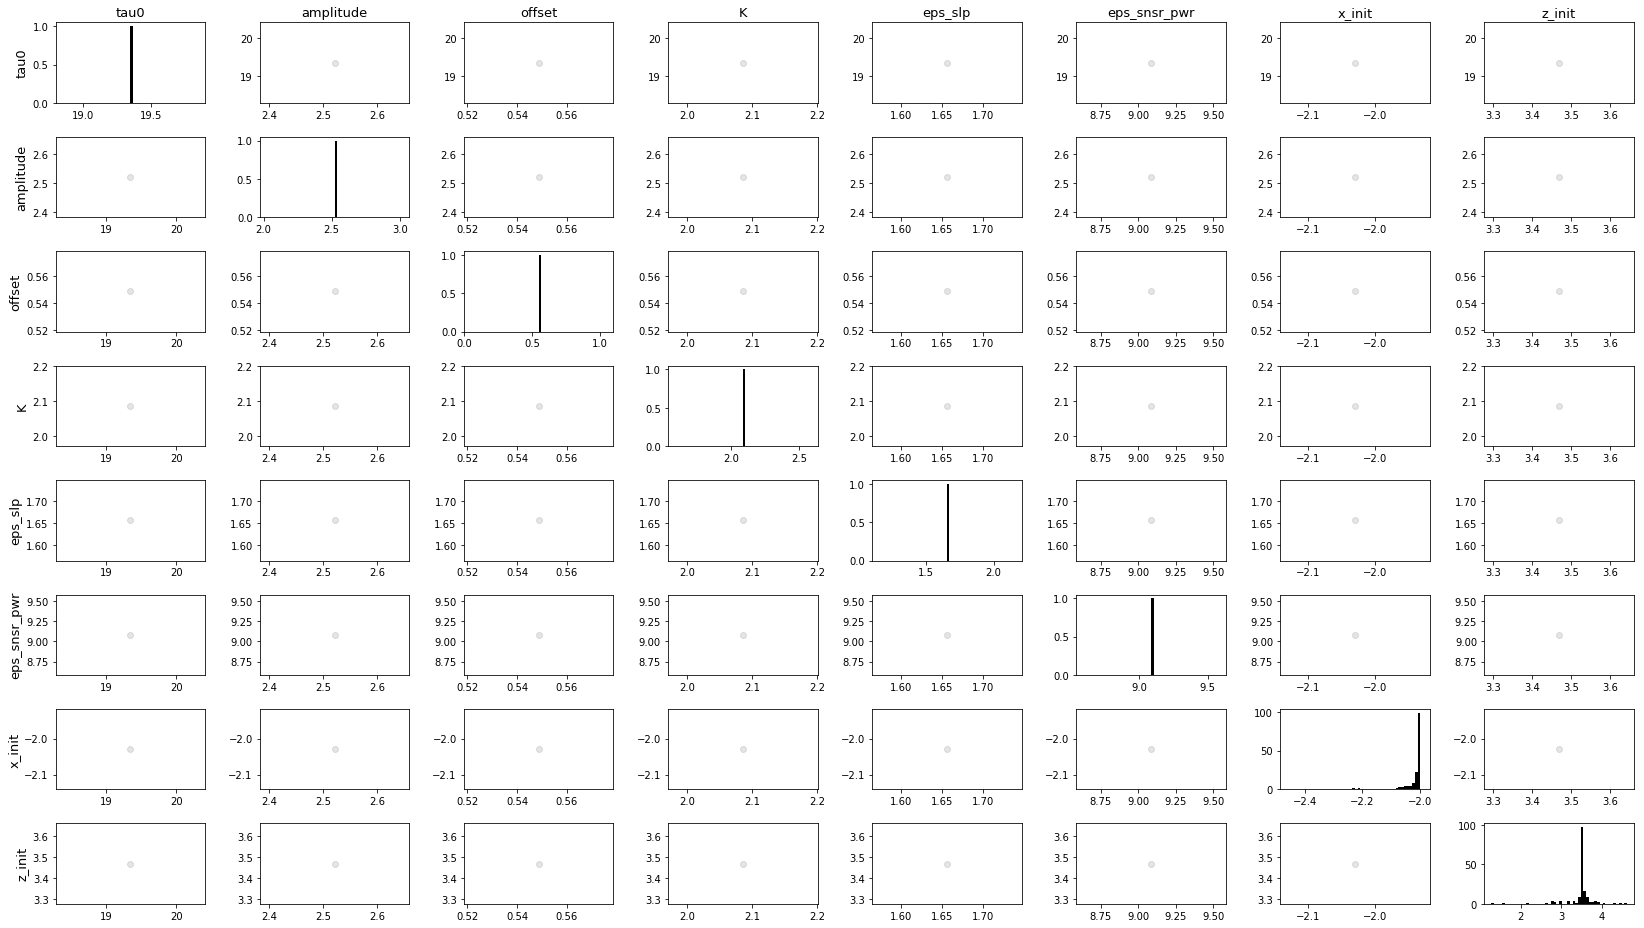

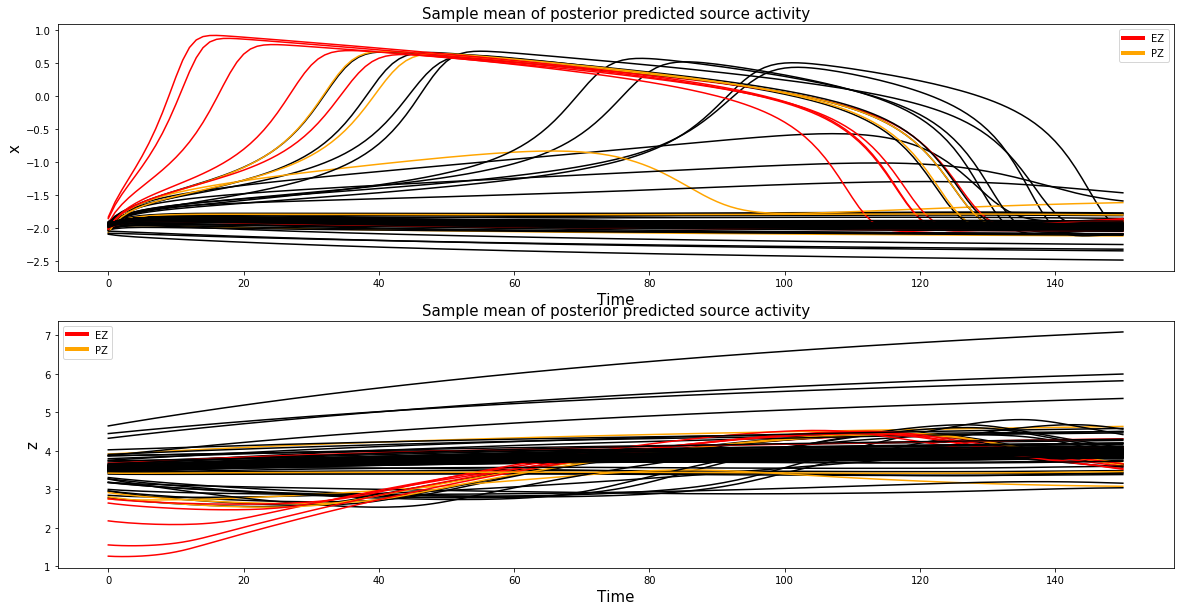

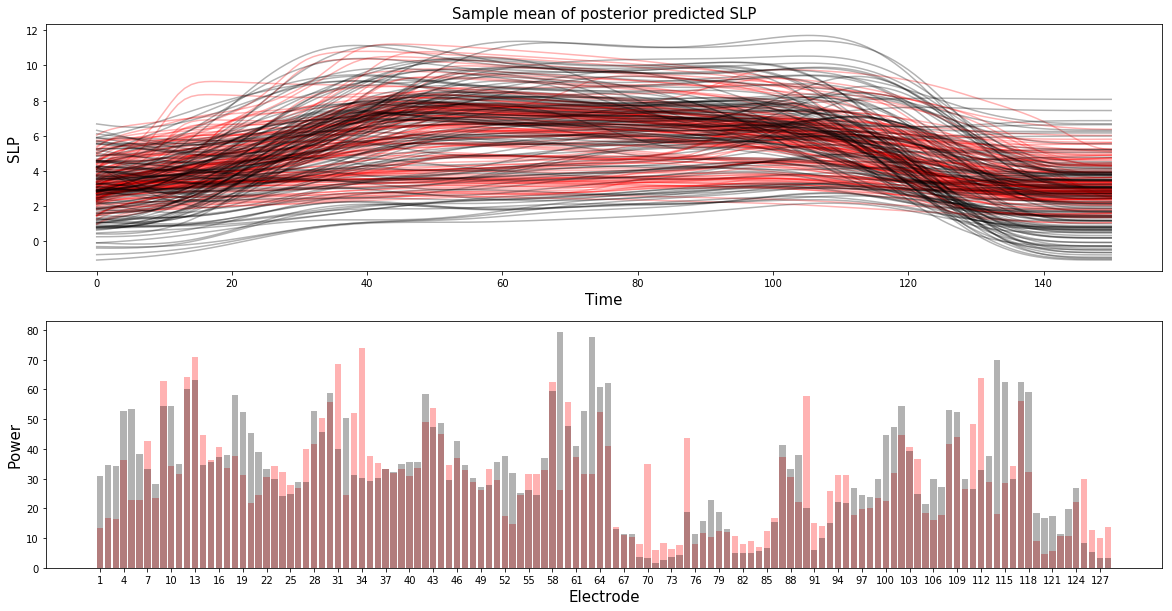

In [32]:
# import importlib
# importlib.reload(lib.plots.stan)

# ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
chains = [1,2,3,4]
#chains = [1]
for i,chain_no in enumerate(chains):
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'])
    lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.pair_plots(pstr_samples, ['tau0', 'amplitude', 'offset', 'K', 'eps_slp', 'eps_snsr_pwr', 'x_init', 'z_init'],
                              figname=f'{results_dir}/figures/params_pair_plots_{fname_suffix}_chain{chain_no}.png')
    lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ez_hyp, pz_hyp,
                               figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}_chain{chain_no}.png')
    #lib.plots.stan.plot_feature(pstr_samples['mu_slp'].mean(axis=0),ez_hyp, pz_hyp,
                               #figname=f'{results_dir}/figures/posterior_predicted_muslp_{fname_suffix}_chain{chain_no}.png', giveylable='out slp', givetitle='Predictive slp')
    lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                                   data, figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}_chain{chain_no}.png')



In [33]:
all_fb_d0=np.load(f'{results_dir}/EZdelay/ez_prior_{szr_name}.npy')
d0_prior=np.mean(all_fb_d0,axis=0)
ez_prior=np.where(d0_prior>0.5)

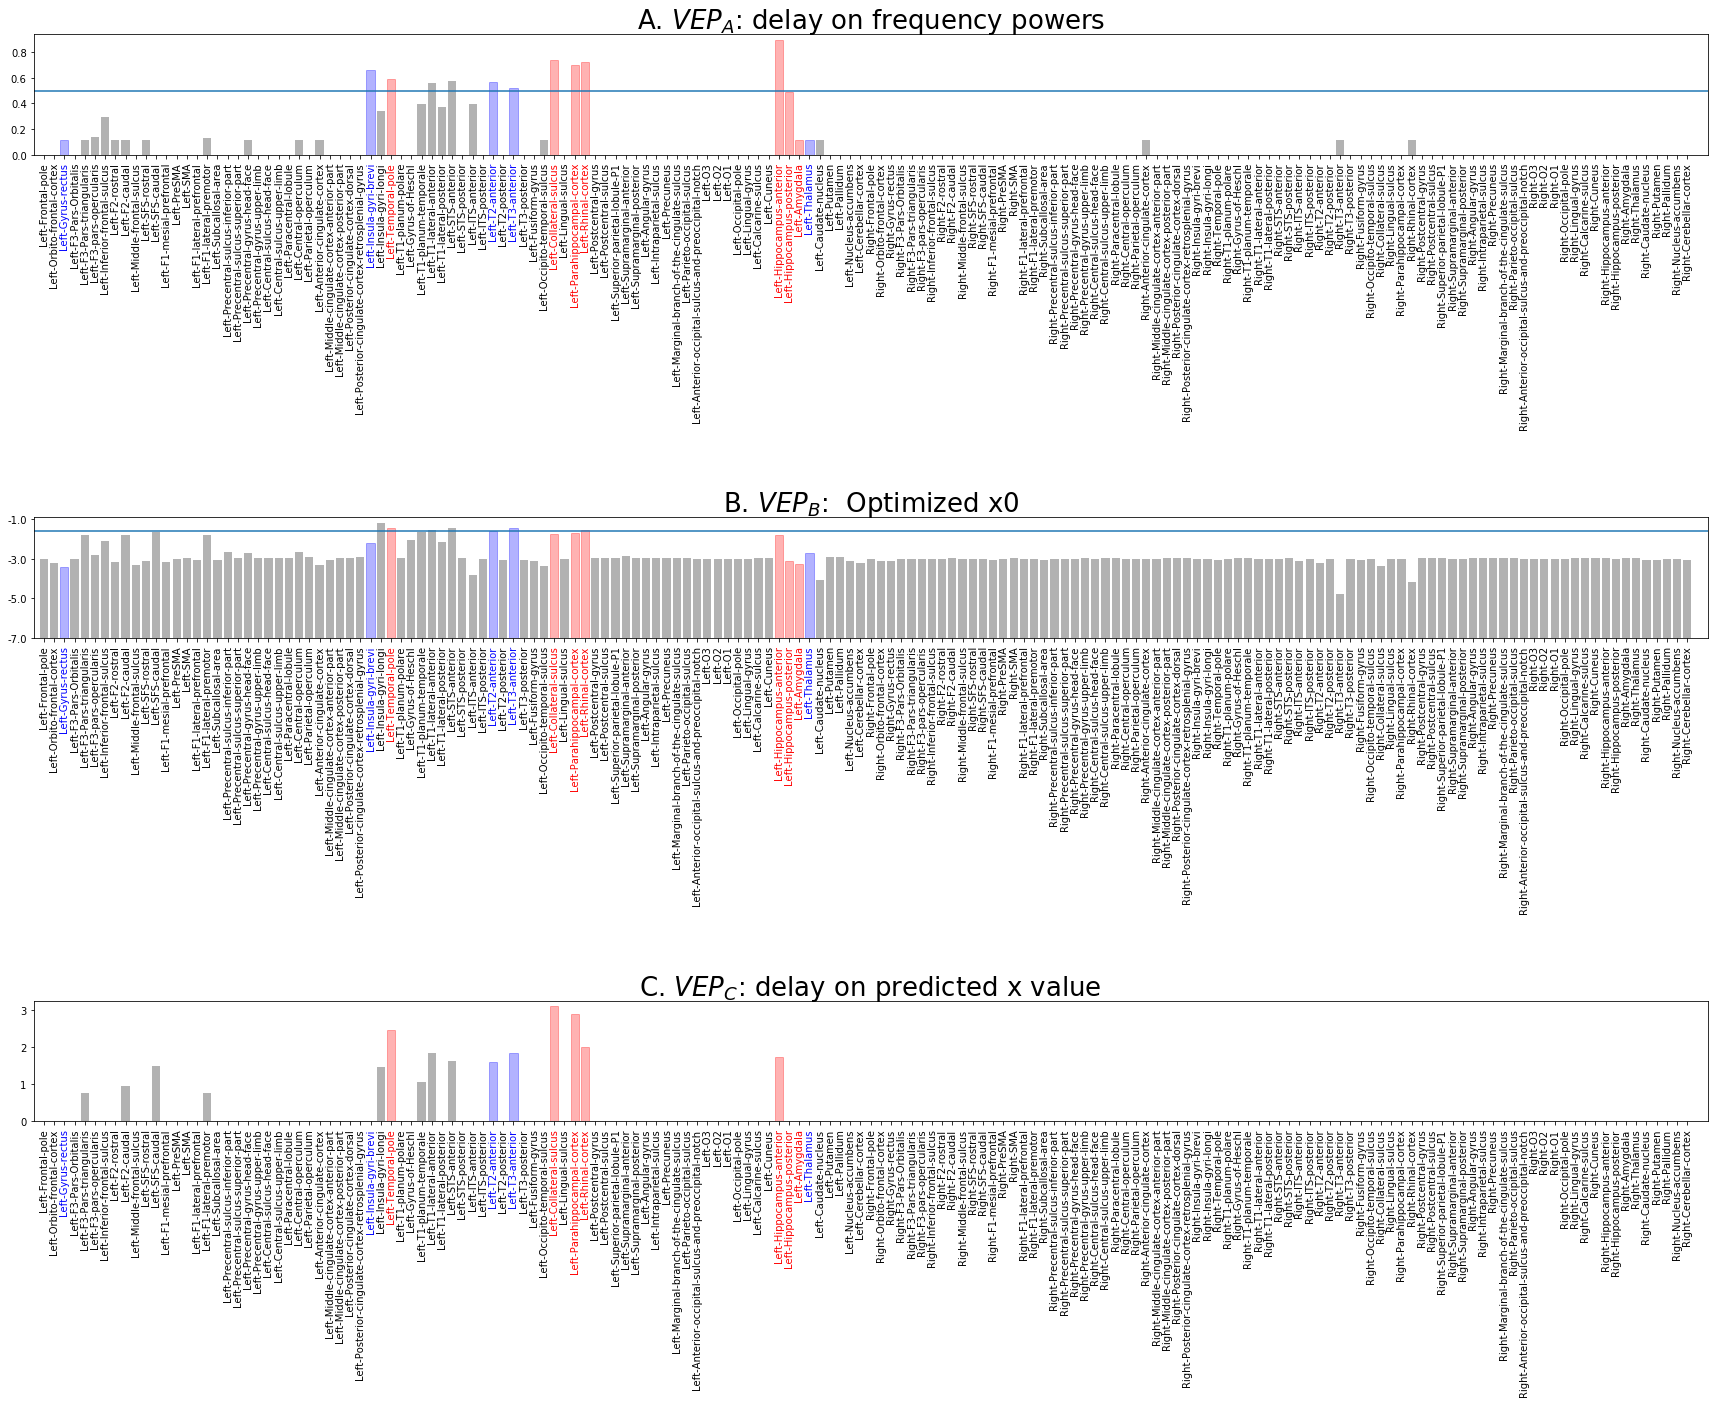

In [40]:
#lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ez_hyp, figsize=(30,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}_chain{chain_no}.png')
import matplotlib.gridspec as gridspec
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain1.csv'])
figsize = [30,20]
x0_infer = pstr_samples['x0']
ns = x0_infer.shape[1]
plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3,1,hspace = 3)
#ax = plt.subplot(3,1,2)


#plt.figure(figsize=figsize)
#gs = gridspec.GridSpec(1,2,width_ratios = [1,8])

#ax = plt.subplot(3,1,1)
ax=plt.subplot(gs[0,0])
barlist=plt.bar(np.arange(0, ns), d0_prior, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

for ichanvep in ezh_all[patient_id]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[patient_id]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('A. $VEP_A$: delay on frequency powers', fontsize = 26);
ax.axhline(0.5)
plt.xlim([-1,163])

ax=plt.subplot(gs[1,0])
barlist=plt.bar(np.arange(0, ns), x0_infer[0]+7, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
ax.axhline(-1.6+7)
for ichanvep in ezh_all[patient_id]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[patient_id]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('B. $VEP_B$:  Optimized x0', fontsize = 26)       
plt.xlim([-1,163])
ax.set_yticklabels(item-7. for item in ax.get_yticks())


ax=plt.subplot(gs[2,0])
#ax = plt.subplot(3,1,3)
#plt.figure(figsize=figsize)
barlist=plt.bar(np.arange(0, ns), ez_pred, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

for ichanvep in ezh_all[patient_id]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[patient_id]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('C. $VEP_C$: delay on predicted x value', fontsize = 26);
plt.xlim([-1,163])
figname=f'{results_dir}/figures/Vep3value_{fname_suffix}_chain{chain_no}.png'
plt.savefig(figname)

A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


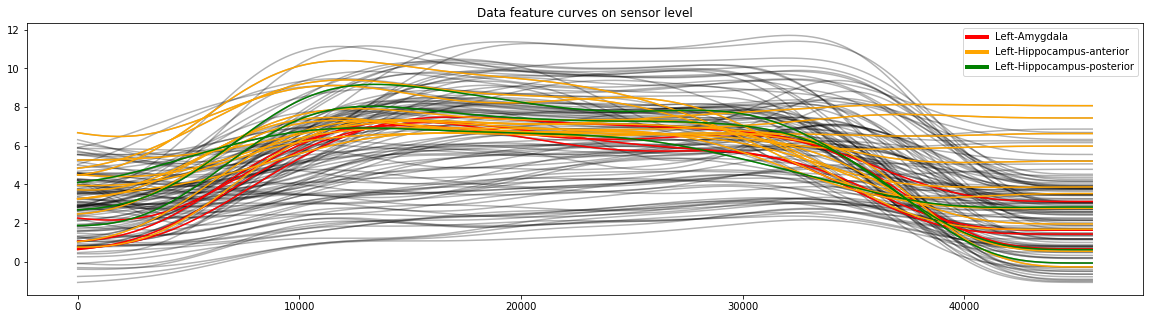

In [41]:
roi_sel=['Left-Amygdala','Left-Hippocampus-anterior','Left-Hippocampus-posterior']
color = ['red','orange','green','blue']
add='False Negative'
#roi_sel = ['Left-Hippocampus-posterior', 'Left-Hippocampus-anterior']
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)

legend_elements = []
for il, ilabel in enumerate(roi_sel):
    legend_elements.append(Line2D([0], [0], color=color[il], linewidth=4, label=ilabel))

plt.plot(slp, color='black', alpha=0.3);



for idroi, iroi in enumerate(roi_sel):
    ez_contacts_ = []

    for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
        if roi[indroi_iv]== iroi:
            print(ibip_elec, ': ', roi[indroi_iv])
            ez_contacts_.append(ibip_elec)
    m_ez = np.array([_ in ez_contacts_ for _ in bip.ch_names])
    
    plt.plot(slp[:,m_ez],color=legend_elements[idroi].get_color(),alpha = 1);
       

plt.legend(handles=legend_elements)
plt.title('Data feature curves on sensor level')
figname=f'{results_dir}/figures/fdfc_A_{fname_suffix}_{add}.png'
plt.savefig(figname)
#plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
#plt.axvline(base_length)
#plt.axvline(len(slp)-base_length)

A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


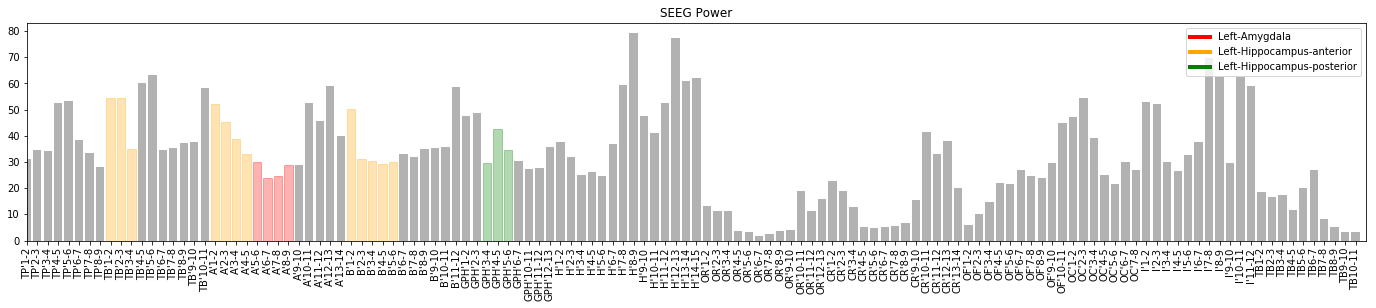

In [42]:
#roi_sel = ['Left-Hippocampus-posterior', 'Left-Hippocampus-anterior']
#roi_sel=['Left-SFS-caudal']
#add='left-SFS-caudal'
plt.figure(figsize=(24,4))

power=(data['slp']**2).mean(axis=0)
barlist=plt.bar(np.arange(0, len(power)), power, color='black', alpha=0.3)
plt.xticks(np.r_[:len(bip.ch_names)], bip.ch_names, rotation = 90);

for idroi, iroi in enumerate(roi_sel):
    ez_contacts_ = []

    for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
        if roi[indroi_iv]== iroi:
            print(ibip_elec, ': ', roi[indroi_iv])
            ez_contacts_.append(ibip_elec)
    m_ez = np.array([_ in ez_contacts_ for _ in bip.ch_names])
    
    
    for ichanvep in np.where(m_ez == True)[0]:
        barlist[ichanvep].set_color(legend_elements[idroi].get_color())
#plt.plot(slp[:,m_ez],color=legend_elements[idroi].get_color(),alpha = 1);
plt.title('SEEG Power')
plt.legend(handles=legend_elements)  
plt.xlim([0,len(bip.ch_names)])
figname=f'{results_dir}/figures/fdfc_C_{fname_suffix}_{add}.png'
plt.savefig(figname)
#plt.gca().get_xticklabels()[m_ez].set_color(legend_elements[idroi].get_color())
 

A'5-6 :  Left-Amygdala
A'6-7 :  Left-Amygdala
A'7-8 :  Left-Amygdala
A'8-9 :  Left-Amygdala
TB'1-2 :  Left-Hippocampus-anterior
TB'2-3 :  Left-Hippocampus-anterior
TB'3-4 :  Left-Hippocampus-anterior
A'1-2 :  Left-Hippocampus-anterior
A'2-3 :  Left-Hippocampus-anterior
A'3-4 :  Left-Hippocampus-anterior
A'4-5 :  Left-Hippocampus-anterior
B'1-2 :  Left-Hippocampus-anterior
B'2-3 :  Left-Hippocampus-anterior
B'3-4 :  Left-Hippocampus-anterior
B'4-5 :  Left-Hippocampus-anterior
B'5-6 :  Left-Hippocampus-anterior
GPH'3-4 :  Left-Hippocampus-posterior
GPH'4-5 :  Left-Hippocampus-posterior
GPH'5-6 :  Left-Hippocampus-posterior


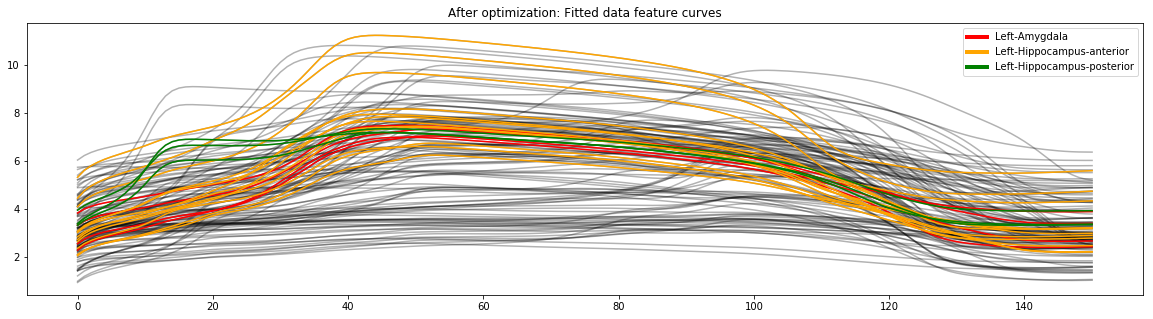

In [43]:
plt.figure(figsize=(20,5))
ns=162
vep_smax = np.zeros(ns)

mu_slp=pstr_samples['mu_slp'].mean(axis=0)



plt.plot(mu_slp, color='black', alpha=0.3);



for idroi, iroi in enumerate(roi_sel):
    ez_contacts_ = []

    for ibip_elec, indroi_iv in zip(bip.ch_names,np.argmax(data['gain'],axis=1)):
        if roi[indroi_iv]== iroi:
            print(ibip_elec, ': ', roi[indroi_iv])
            ez_contacts_.append(ibip_elec)
    m_ez = np.array([_ in ez_contacts_ for _ in bip.ch_names])
    
    plt.plot(mu_slp[:,m_ez],color=legend_elements[idroi].get_color(),alpha = 1);
       

plt.legend(handles=legend_elements)
plt.title('After optimization: Fitted data feature curves')
figname=f'{results_dir}/figures/fdfc_B_{fname_suffix}_{add}.png'
plt.savefig(figname)